# Sentiment Signal Backtesting

This notebook backtests our sentiment-based trading signals against benchmark strategies.

## Strategy Overview
- **Portfolio**: $10,000 starting capital
- **Signals**: Long on bullish sentiment, Short on bearish sentiment
- **Risk Management**: Position sizing, stop-loss, take-profit
- **Benchmarks**: S&P 500, NASDAQ 100, Total World Stock (VT)

## 1. Setup & Imports

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
from tqdm import tqdm
from utils import get_oracle_connection, fetch_historical_prices, adjust_to_trading_day

# Configuration
INITIAL_CAPITAL = 10000
START_DATE = "2024-01-01"
END_DATE = "2024-12-31"

# Risk Management Parameters
MAX_POSITION_SIZE = 0.10  # Max 10% of portfolio per trade
STOP_LOSS_PCT = 0.07      # 7% stop loss
TAKE_PROFIT_PCT = 0.10    # 10% take profit
MAX_HOLDING_DAYS = 5      # 5 days max holding
LONG_ONLY = False         # Take both long and short trades 

print("Setup complete")

Setup complete


## 2. Load Signals from Database

In [19]:
# Load filtered signals from Oracle
conn = get_oracle_connection()

if not conn:
    raise ConnectionError("Failed to establish a connection to the Oracle database.")

query = """
SELECT *
FROM filtered_signals
ORDER BY signal_date, ticker
"""

signals_df = pd.read_sql_query(query, conn)
conn.close()

# Convert date column
signals_df['SIGNAL_DATE'] = pd.to_datetime(signals_df['SIGNAL_DATE'])

print(f"Loaded {len(signals_df)} signals")
print(f"Date range: {signals_df['SIGNAL_DATE'].min()} to {signals_df['SIGNAL_DATE'].max()}")
print(f"Unique tickers: {signals_df['TICKER'].nunique()}")
print(f"\nSignal type distribution:")
print(signals_df['SIGNAL_TYPE'].value_counts())
print(f"\nSignal direction distribution:")
print(signals_df['SIGNAL_DIRECTION'].value_counts())

Oracle connection successful!


/var/folders/5k/xsh6xzj10l121lg2lr_6rpkm0000gn/T/ipykernel_31240/3503493225.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  signals_df = pd.read_sql_query(query, conn)


Loaded 1810 signals
Date range: 2024-01-30 00:00:00 to 2024-12-30 00:00:00
Unique tickers: 274

Signal type distribution:
SIGNAL_TYPE
SELL    1018
BUY      792
Name: count, dtype: int64

Signal direction distribution:
SIGNAL_DIRECTION
-1    1018
 1     792
Name: count, dtype: int64


## 3. Fetch Price Data for All Tickers

In [20]:
# Fetch historical prices for all unique tickers
unique_tickers = signals_df['TICKER'].unique()
price_cache = {}
failed_tickers = set()

for ticker in tqdm(unique_tickers, desc="Fetching price data"):
    try:
        df_prices = fetch_historical_prices(ticker, START_DATE, END_DATE)
        if df_prices is not None and not df_prices.empty:
            # Normalize index
            df_prices.index = pd.to_datetime(df_prices.index).tz_localize(None).normalize()
            price_cache[ticker] = df_prices
    except Exception as e:
        failed_tickers.add(ticker)

print(f"\nSuccessfully fetched: {len(price_cache)} tickers")
print(f"Failed: {len(failed_tickers)} tickers")

Fetching price data: 100%|██████████| 274/274 [00:36<00:00,  7.58it/s]


Successfully fetched: 274 tickers
Failed: 0 tickers


## 4. Backtesting Engine

In [21]:
class Trade:
    def __init__(self, ticker, entry_date, entry_price, direction, position_size, shares, signal_score=None):
        self.ticker = ticker
        self.entry_date = entry_date
        self.entry_price = entry_price
        self.direction = direction  # 'long' or 'short'
        self.position_size = position_size
        self.shares = shares
        self.signal_score = signal_score  # Composite signal quality score
        self.exit_date = None
        self.exit_price = None
        self.exit_reason = None
        self.pnl = 0
        self.pnl_pct = 0


def calculate_position_size(signal, cash, max_position_size):
    """
    Calculate position size based on multiple signal quality metrics.
    
    Uses columns from filtered_signals:
    - SIGNAL_SCORE / Z_SCORE: Signal strength from sentiment shock detection
    - WINDOW_SENTIMENT: Current sentiment level
    - WINDOW_MENTIONS: Number of mentions (confidence proxy)
    - PCT_3D_Z, RET_Z, VOL_Z: Statistical significance of recent price moves
    - VOL_EXPANSION: Volume confirmation
    - ATR_MOVE: Volatility-adjusted move size
    
    Returns: (position_size, position_pct, composite_score)
    """
    # Helper to safely get numeric values
    def safe_get(key, default=0.0):
        val = signal.get(key, default)
        return float(val) if pd.notna(val) else default
    
    # === 1. Sentiment Quality Score (0-1) ===
    # Use window sentiment and z-score as quality indicators
    window_sentiment = safe_get('WINDOW_SENTIMENT', 0)
    z_score = abs(safe_get('Z_SCORE', 0))
    window_mentions = safe_get('WINDOW_MENTIONS', 5)
    
    # Sentiment magnitude (normalized - values typically range -0.5 to 0.5)
    sentiment_magnitude = min(abs(window_sentiment) * 2, 1.0)
    
    # Z-score indicates statistical significance (z > 2 is significant)
    z_score_quality = min(z_score / 3.0, 1.0)  # Normalize: z=3 -> 1.0
    
    # Mention confidence (more mentions = more reliable signal)
    mention_confidence = min(window_mentions / 20.0, 1.0)  # 20+ mentions = full confidence
    
    sentiment_quality = 0.4 * sentiment_magnitude + 0.4 * z_score_quality + 0.2 * mention_confidence
    
    # === 2. Market Move Significance Score (0-1) ===
    # These indicate if price has moved significantly (but not too much that we missed it)
    pct_3d_z = abs(safe_get('PCT_3D_Z', 0))
    ret_z = abs(safe_get('RET_Z', 0))
    vol_z = abs(safe_get('VOL_Z', 0))
    
    # We want some move but not extreme (filter caught extreme moves)
    # Lower values here mean market hasn't moved much yet = good entry opportunity
    # Score higher when z-scores are LOW (market hasn't moved much yet)
    z_avg = (pct_3d_z + ret_z + vol_z) / 3
    # Invert: low z (< 1.5) = good entry = high score; high z = risky = lower score
    entry_opportunity = max(0, 1.0 - z_avg / 2.0)  # z=0 -> 1.0, z=2 -> 0
    
    # === 3. Volume/Volatility Confirmation Score (0-1) ===
    vol_expansion = safe_get('VOL_EXPANSION', 1.0)
    atr_move = abs(safe_get('ATR_MOVE', 0))
    
    # Vol expansion between 1.0 and 1.75 is ideal (some interest but not exhaustion)
    if vol_expansion < 1.0:
        vol_score = vol_expansion  # Low volume = less confidence
    elif vol_expansion <= 1.75:
        vol_score = 1.0  # Ideal range
    else:
        vol_score = max(0, 1.0 - (vol_expansion - 1.75) / 2)  # Penalize very high volume
    
    # ATR move between 0.5 and 2.0 is ideal
    atr_score = min(atr_move / 1.5, 1.0) if atr_move < 2.0 else max(0, 1.0 - (atr_move - 2.0) / 2)
    
    volatility_score = 0.5 * vol_score + 0.5 * atr_score
    
    # === 4. Signal Strength (from original signal score) ===
    signal_strength = abs(safe_get('SIGNAL_SCORE', 0))
    signal_strength = min(signal_strength / 3.0, 1.0)  # Normalize z-score style
    
    # === Composite Score (weighted average) ===
    composite_score = (
        0.35 * sentiment_quality +      # Sentiment quality matters most
        0.25 * signal_strength +         # Original signal strength
        0.20 * entry_opportunity +       # Good entry timing
        0.20 * volatility_score          # Volume/volatility confirmation
    )
    
    # === Position Sizing ===
    # Base: 3% of portfolio
    # Max boost: up to additional 7% based on composite score
    # Range: 3% to 10% (or max_position_size)
    base_pct = 0.03
    boost_pct = 0.07 * composite_score
    position_pct = min(base_pct + boost_pct, max_position_size)
    
    position_size = cash * position_pct
    
    return position_size, position_pct, composite_score


def run_backtest(signals_df, price_cache, initial_capital, max_position_size, 
                 stop_loss_pct, take_profit_pct, max_holding_days):
    """
    Run backtest with risk management and intelligent position sizing.
    """
    # Sort signals by date
    signals = signals_df.sort_values('SIGNAL_DATE').copy()
    
    # Portfolio tracking
    cash = initial_capital
    portfolio_value = initial_capital
    open_positions = {}  # ticker -> Trade
    closed_trades = []
    
    # Daily portfolio value tracking
    all_dates = pd.date_range(start=START_DATE, end=END_DATE, freq='B')  # Business days
    portfolio_history = []
    
    for current_date in all_dates:
        current_date = pd.Timestamp(current_date).normalize()
        
        # 1. Check existing positions for exit conditions
        tickers_to_close = []
        for ticker, trade in open_positions.items():
            if ticker not in price_cache:
                continue
            
            prices = price_cache[ticker]
            if current_date not in prices.index:
                continue
            
            current_price = prices.loc[current_date, 'Close']
            days_held = (current_date - trade.entry_date).days
            
            # Calculate current P&L
            if trade.direction == 'long':
                pnl_pct = (current_price - trade.entry_price) / trade.entry_price
            else:  # short
                pnl_pct = (trade.entry_price - current_price) / trade.entry_price
            
            # Check exit conditions
            exit_reason = None
            if pnl_pct <= -stop_loss_pct:
                exit_reason = 'stop_loss'
            elif pnl_pct >= take_profit_pct:
                exit_reason = 'take_profit'
            elif days_held >= max_holding_days:
                exit_reason = 'max_holding'
            
            if exit_reason:
                trade.exit_date = current_date
                trade.exit_price = current_price
                trade.exit_reason = exit_reason
                trade.pnl_pct = pnl_pct
                trade.pnl = trade.position_size * pnl_pct
                
                # Return capital + P&L to cash
                cash += trade.position_size + trade.pnl
                closed_trades.append(trade)
                tickers_to_close.append(ticker)
        
        # Remove closed positions
        for ticker in tickers_to_close:
            del open_positions[ticker]
        
        # 2. Process new signals for this date
        day_signals = signals[signals['SIGNAL_DATE'].dt.normalize() == current_date]
        
        for _, signal in day_signals.iterrows():
            ticker = signal['TICKER']
            
            # Skip if already have position in this ticker
            if ticker in open_positions:
                continue
            
            # Skip if no price data
            if ticker not in price_cache:
                continue
            
            prices = price_cache[ticker]
            
            # Enter on next trading day (can't trade same day as signal)
            future_dates = prices.index[prices.index > current_date]
            if len(future_dates) == 0:
                continue
            
            entry_date = future_dates[0]
            entry_price = prices.loc[entry_date, 'Open']
            
            # Determine direction based on SIGNAL_TYPE (BUY/SELL) or SIGNAL_DIRECTION (1/-1)
            signal_type = signal.get('SIGNAL_TYPE', '')
            signal_direction = signal.get('SIGNAL_DIRECTION', 0)
            
            if signal_type == 'BUY' or signal_direction == 1:
                direction = 'long'
            elif signal_type == 'SELL' or signal_direction == -1:
                direction = 'short'
            else:
                continue  # Skip signals with unknown direction
            
            # Calculate position size using all signal metrics
            position_size, position_pct, signal_score = calculate_position_size(
                signal, cash, max_position_size
            )
            
            # Skip if not enough cash
            if position_size < 100 or cash < position_size:
                continue
            
            shares = position_size / entry_price
            
            # Open position with signal score tracking
            trade = Trade(ticker, entry_date, entry_price, direction, position_size, shares, signal_score)
            open_positions[ticker] = trade
            cash -= position_size
        
        # 3. Calculate total portfolio value
        positions_value = 0
        for ticker, trade in open_positions.items():
            if ticker in price_cache and current_date in price_cache[ticker].index:
                current_price = price_cache[ticker].loc[current_date, 'Close']
                if trade.direction == 'long':
                    pnl_pct = (current_price - trade.entry_price) / trade.entry_price
                else:
                    pnl_pct = (trade.entry_price - current_price) / trade.entry_price
                positions_value += trade.position_size * (1 + pnl_pct)
            else:
                positions_value += trade.position_size  # Use entry value if no price
        
        portfolio_value = cash + positions_value
        portfolio_history.append({
            'date': current_date,
            'portfolio_value': portfolio_value,
            'cash': cash,
            'positions_value': positions_value,
            'n_positions': len(open_positions)
        })
    
    # Close any remaining positions at end
    for ticker, trade in open_positions.items():
        if ticker in price_cache:
            last_date = price_cache[ticker].index[-1]
            trade.exit_date = last_date
            trade.exit_price = price_cache[ticker].loc[last_date, 'Close']
            trade.exit_reason = 'end_of_period'
            if trade.direction == 'long':
                trade.pnl_pct = (trade.exit_price - trade.entry_price) / trade.entry_price
            else:
                trade.pnl_pct = (trade.entry_price - trade.exit_price) / trade.entry_price
            trade.pnl = trade.position_size * trade.pnl_pct
            closed_trades.append(trade)
    
    return pd.DataFrame(portfolio_history), closed_trades

print("Backtesting engine defined with intelligent position sizing")
print("\nPosition sizing uses:")
print("  • Sentiment Quality: WINDOW_SENTIMENT, Z_SCORE, WINDOW_MENTIONS")
print("  • Signal Strength: SIGNAL_SCORE")  
print("  • Entry Timing: PCT_3D_Z, RET_Z, VOL_Z (lower = better entry)")
print("  • Volume/Volatility: VOL_EXPANSION, ATR_MOVE")

Backtesting engine defined with intelligent position sizing

Position sizing uses:
  • Sentiment Quality: WINDOW_SENTIMENT, Z_SCORE, WINDOW_MENTIONS
  • Signal Strength: SIGNAL_SCORE
  • Entry Timing: PCT_3D_Z, RET_Z, VOL_Z (lower = better entry)
  • Volume/Volatility: VOL_EXPANSION, ATR_MOVE


## 5. Run Backtest

Using optimized parameters from `best-params.ipynb`.

In [22]:
# Run backtest with optimized parameters (from best-params.ipynb)
print("Running backtest with optimized parameters:")
print(f"   Stop Loss: {STOP_LOSS_PCT*100:.0f}%")
print(f"   Take Profit: {TAKE_PROFIT_PCT*100:.0f}%")
print(f"   Max Holding: {MAX_HOLDING_DAYS} days")
print(f"   Long Only: {LONG_ONLY}")

# Filter signals based on strategy
if LONG_ONLY:
    final_signals = signals_df[
        (signals_df['SIGNAL_TYPE'] == 'BUY') | (signals_df['SIGNAL_DIRECTION'] == 1)
    ].copy()
    print(f"\n   Using LONG-ONLY signals: {len(final_signals)} signals")
else:
    final_signals = signals_df.copy()
    print(f"\n   Using ALL signals (long & short): {len(final_signals)} signals")

# Run the backtest
portfolio_history, trades = run_backtest(
    signals_df=final_signals,
    price_cache=price_cache,
    initial_capital=INITIAL_CAPITAL,
    max_position_size=MAX_POSITION_SIZE,
    stop_loss_pct=STOP_LOSS_PCT,
    take_profit_pct=TAKE_PROFIT_PCT,
    max_holding_days=MAX_HOLDING_DAYS
)

print(f"\n✓ Backtest complete!")
print(f"Total trades: {len(trades)}")
print(f"Final portfolio value: ${portfolio_history['portfolio_value'].iloc[-1]:,.2f}")
print(f"Total return: {(portfolio_history['portfolio_value'].iloc[-1] / INITIAL_CAPITAL - 1) * 100:.2f}%")

# Direction breakdown
long_trades = sum(1 for t in trades if t.direction == 'long')
short_trades = len(trades) - long_trades
print(f"Direction: {long_trades} long, {short_trades} short")

Running backtest with optimized parameters:
   Stop Loss: 7%
   Take Profit: 10%
   Max Holding: 5 days
   Long Only: False

   Using ALL signals (long & short): 1810 signals

✓ Backtest complete!
Total trades: 771
Final portfolio value: $11,428.42
Total return: 14.28%
Direction: 336 long, 435 short


## 6. Trade Analysis

In [23]:
# Analyze trades
trades_df = pd.DataFrame([{
    'ticker': t.ticker,
    'entry_date': t.entry_date,
    'exit_date': t.exit_date,
    'direction': t.direction,
    'entry_price': t.entry_price,
    'exit_price': t.exit_price,
    'position_size': t.position_size,
    'signal_score': t.signal_score,  # Composite signal quality score
    'pnl': t.pnl,
    'pnl_pct': t.pnl_pct * 100,
    'exit_reason': t.exit_reason
} for t in trades])

# Summary statistics
winning_trades = trades_df[trades_df['pnl'] > 0]
losing_trades = trades_df[trades_df['pnl'] < 0]

print("=" * 60)
print("TRADE STATISTICS")
print("=" * 60)
print(f"Total trades: {len(trades_df)}")
print(f"Winning trades: {len(winning_trades)} ({len(winning_trades)/len(trades_df)*100:.1f}%)")
print(f"Losing trades: {len(losing_trades)} ({len(losing_trades)/len(trades_df)*100:.1f}%)")
print(f"\nAverage P&L per trade: ${trades_df['pnl'].mean():.2f}")
print(f"Average winning trade: ${winning_trades['pnl'].mean():.2f}" if len(winning_trades) > 0 else "No winning trades")
print(f"Average losing trade: ${losing_trades['pnl'].mean():.2f}" if len(losing_trades) > 0 else "No losing trades")
print(f"\nTotal P&L: ${trades_df['pnl'].sum():.2f}")

print(f"\nExit reasons:")
print(trades_df['exit_reason'].value_counts())

print(f"\nDirection breakdown:")
print(trades_df['direction'].value_counts())

# === Signal Score Analysis ===
print("\n" + "=" * 60)
print("SIGNAL SCORE ANALYSIS (Position Sizing Quality)")
print("=" * 60)
print(f"Average signal score: {trades_df['signal_score'].mean():.3f}")
print(f"Signal score range: {trades_df['signal_score'].min():.3f} - {trades_df['signal_score'].max():.3f}")

# Correlation between signal score and performance
correlation = trades_df['signal_score'].corr(trades_df['pnl_pct'])
print(f"\nCorrelation (signal_score vs pnl%): {correlation:.3f}")

# Performance by signal score quartile
trades_df['score_quartile'] = pd.qcut(trades_df['signal_score'], q=4, labels=['Q1 (Low)', 'Q2', 'Q3', 'Q4 (High)'])
quartile_stats = trades_df.groupby('score_quartile').agg({
    'pnl': ['mean', 'sum', 'count'],
    'pnl_pct': 'mean',
    'position_size': 'mean'
}).round(2)
quartile_stats.columns = ['Avg P&L ($)', 'Total P&L ($)', 'Trades', 'Avg P&L (%)', 'Avg Position ($)']
print(f"\nPerformance by Signal Score Quartile:")
print(quartile_stats.to_string())

# Win rate by quartile
print(f"\nWin Rate by Signal Score Quartile:")
for q in ['Q1 (Low)', 'Q2', 'Q3', 'Q4 (High)']:
    q_trades = trades_df[trades_df['score_quartile'] == q]
    q_wins = len(q_trades[q_trades['pnl'] > 0])
    q_win_rate = q_wins / len(q_trades) * 100 if len(q_trades) > 0 else 0
    print(f"  {q}: {q_win_rate:.1f}% ({q_wins}/{len(q_trades)} trades)")

# Show sample trades
print(f"\nSample trades (sorted by signal score):")
trades_df.sort_values('signal_score', ascending=False).head(10)

TRADE STATISTICS
Total trades: 771
Winning trades: 406 (52.7%)
Losing trades: 365 (47.3%)

Average P&L per trade: $1.93
Average winning trade: $17.43
Average losing trade: $-15.33

Total P&L: $1484.65

Exit reasons:
exit_reason
max_holding      628
stop_loss         80
take_profit       55
end_of_period      8
Name: count, dtype: int64

Direction breakdown:
direction
short    435
long     336
Name: count, dtype: int64

SIGNAL SCORE ANALYSIS (Position Sizing Quality)
Average signal score: 0.600
Signal score range: 0.400 - 0.854

Correlation (signal_score vs pnl%): -0.013

Performance by Signal Score Quartile:
                Avg P&L ($)  Total P&L ($)  Trades  Avg P&L (%)  Avg Position ($)
score_quartile                                                                   
Q1 (Low)               3.03         585.07     193         0.83            374.16
Q2                     2.13         410.16     193         0.63            374.41
Q3                    -0.92        -176.47     192      

/var/folders/5k/xsh6xzj10l121lg2lr_6rpkm0000gn/T/ipykernel_31240/2179506690.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quartile_stats = trades_df.groupby('score_quartile').agg({


,ticker,entry_date,exit_date,direction,entry_price,exit_price,position_size,signal_score,pnl,pnl_pct,exit_reason,score_quartile
576,ACA,2024-10-17,2024-10-22,short,96.581546,92.061768,576.719302,0.853551,26.989042,4.679754,max_holding,Q4 (High)
512,TSM,2024-09-11,2024-09-16,short,160.951524,166.752914,753.885937,0.838063,-27.173317,-3.604433,max_holding,Q4 (High)
159,EVER,2024-04-02,2024-04-08,long,18.730000,19.430000,432.914425,0.826125,16.179415,3.737324,max_holding,Q4 (High)
267,SMCI,2024-05-29,2024-06-03,short,85.862999,77.058998,800.452396,0.823670,82.074743,10.253545,take_profit,Q4 (High)
503,AMZN,2024-09-04,2024-09-09,long,174.479996,175.399994,746.332927,0.823186,3.935264,0.527280,max_holding,Q4 (High)
82,CMG,2024-03-01,2024-03-06,long,53.988998,53.802799,290.846891,0.822543,-1.003083,-0.344884,max_holding,Q4 (High)
111,PLTR,2024-03-14,2024-03-19,long,24.830000,23.799999,443.439246,0.813833,-18.394794,-4.148211,max_holding,Q4 (High)
589,NVDA,2024-10-23,2024-10-28,short,141.989282,140.479736,553.141045,0.808879,5.880667,1.063141,max_holding,Q4 (High)
647,LINK,2024-11-19,2024-11-25,short,3.260000,2.793333,632.847119,0.800333,90.591665,14.314937,take_profit,Q4 (High)
428,TFSA,2024-08-16,2024-08-21,short,21.867521,21.774467,529.962220,0.799721,2.255171,0.425534,max_holding,Q4 (High)


## 6.1 Signal Score vs Performance Visualization

/var/folders/5k/xsh6xzj10l121lg2lr_6rpkm0000gn/T/ipykernel_31240/267910038.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(quartile_data, labels=['Q1\n(Low)', 'Q2', 'Q3', 'Q4\n(High)'], patch_artist=True)


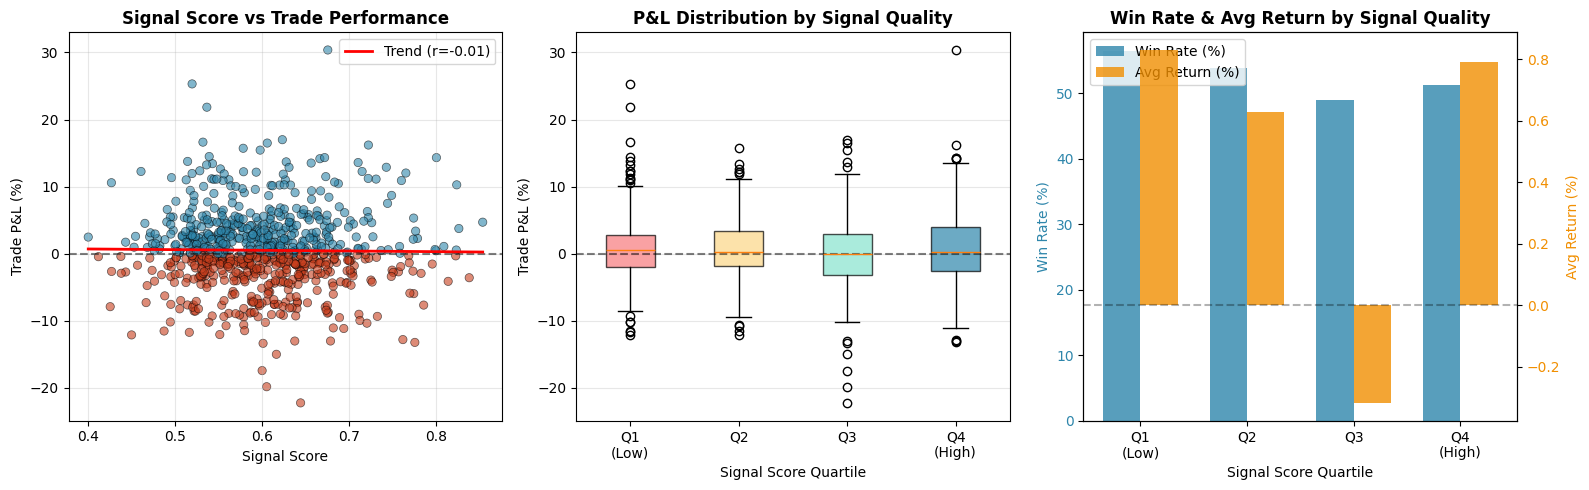

In [24]:
# Visualize signal score vs trade performance
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Scatter: Signal Score vs P&L %
ax1 = axes[0]
colors_scatter = ['#2E86AB' if x >= 0 else '#C73E1D' for x in trades_df['pnl']]
ax1.scatter(trades_df['signal_score'], trades_df['pnl_pct'], c=colors_scatter, alpha=0.6, edgecolors='black', linewidth=0.5)
ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)

# Add regression line
z = np.polyfit(trades_df['signal_score'], trades_df['pnl_pct'], 1)
p = np.poly1d(z)
x_line = np.linspace(trades_df['signal_score'].min(), trades_df['signal_score'].max(), 100)
ax1.plot(x_line, p(x_line), 'r-', linewidth=2, label=f'Trend (r={correlation:.2f})')

ax1.set_xlabel('Signal Score')
ax1.set_ylabel('Trade P&L (%)')
ax1.set_title('Signal Score vs Trade Performance', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Box plot: P&L by Signal Score Quartile
ax2 = axes[1]
quartile_data = [trades_df[trades_df['score_quartile'] == q]['pnl_pct'].values 
                 for q in ['Q1 (Low)', 'Q2', 'Q3', 'Q4 (High)']]
bp = ax2.boxplot(quartile_data, labels=['Q1\n(Low)', 'Q2', 'Q3', 'Q4\n(High)'], patch_artist=True)

# Color boxes
colors_box = ['#f7797d', '#fbd786', '#86e3ce', '#2E86AB']
for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax2.set_xlabel('Signal Score Quartile')
ax2.set_ylabel('Trade P&L (%)')
ax2.set_title('P&L Distribution by Signal Quality', fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# 3. Bar chart: Win Rate & Avg Return by Quartile
ax3 = axes[2]
quartiles = ['Q1 (Low)', 'Q2', 'Q3', 'Q4 (High)']
win_rates = []
avg_returns = []
for q in quartiles:
    q_trades = trades_df[trades_df['score_quartile'] == q]
    win_rates.append(len(q_trades[q_trades['pnl'] > 0]) / len(q_trades) * 100 if len(q_trades) > 0 else 0)
    avg_returns.append(q_trades['pnl_pct'].mean())

x = np.arange(len(quartiles))
width = 0.35

bars1 = ax3.bar(x - width/2, win_rates, width, label='Win Rate (%)', color='#2E86AB', alpha=0.8)
ax3.set_ylabel('Win Rate (%)', color='#2E86AB')
ax3.tick_params(axis='y', labelcolor='#2E86AB')

ax3_twin = ax3.twinx()
bars2 = ax3_twin.bar(x + width/2, avg_returns, width, label='Avg Return (%)', color='#F18F01', alpha=0.8)
ax3_twin.set_ylabel('Avg Return (%)', color='#F18F01')
ax3_twin.tick_params(axis='y', labelcolor='#F18F01')
ax3_twin.axhline(y=0, color='black', linestyle='--', alpha=0.3)

ax3.set_xlabel('Signal Score Quartile')
ax3.set_xticks(x)
ax3.set_xticklabels(['Q1\n(Low)', 'Q2', 'Q3', 'Q4\n(High)'])
ax3.set_title('Win Rate & Avg Return by Signal Quality', fontweight='bold')

# Combined legend
lines1, labels1 = ax3.get_legend_handles_labels()
lines2, labels2 = ax3_twin.get_legend_handles_labels()
ax3.legend([bars1, bars2], ['Win Rate (%)', 'Avg Return (%)'], loc='upper left')

plt.tight_layout()
plt.show()

## 7. Fetch Benchmark Data

In [25]:
# Fetch benchmark data
benchmarks = {
    'S&P 500': 'SPY',
    'NASDAQ 100': 'QQQ', 
    'World Stocks': 'VT'  # Vanguard Total World Stock ETF (global developed + emerging markets)
}

benchmark_data = {}

for name, ticker in benchmarks.items():
    try:
        data = yf.Ticker(ticker).history(start=START_DATE, end=END_DATE)
        if not data.empty:
            data.index = pd.to_datetime(data.index).tz_localize(None).normalize()
            benchmark_data[name] = data
            print(f"✓ {name} ({ticker}): {len(data)} days")
    except Exception as e:
        print(f"✗ {name} ({ticker}): Failed - {e}")

# Calculate benchmark returns (buy & hold from day 1)
benchmark_returns = {}
for name, data in benchmark_data.items():
    initial_price = data['Close'].iloc[0]
    benchmark_returns[name] = (data['Close'] / initial_price) * INITIAL_CAPITAL

print(f"\nLoaded {len(benchmark_data)} benchmarks")

✓ S&P 500 (SPY): 251 days
✓ NASDAQ 100 (QQQ): 251 days
✓ World Stocks (VT): 251 days

Loaded 3 benchmarks
✓ World Stocks (VT): 251 days

Loaded 3 benchmarks


## 8. Performance Visualization

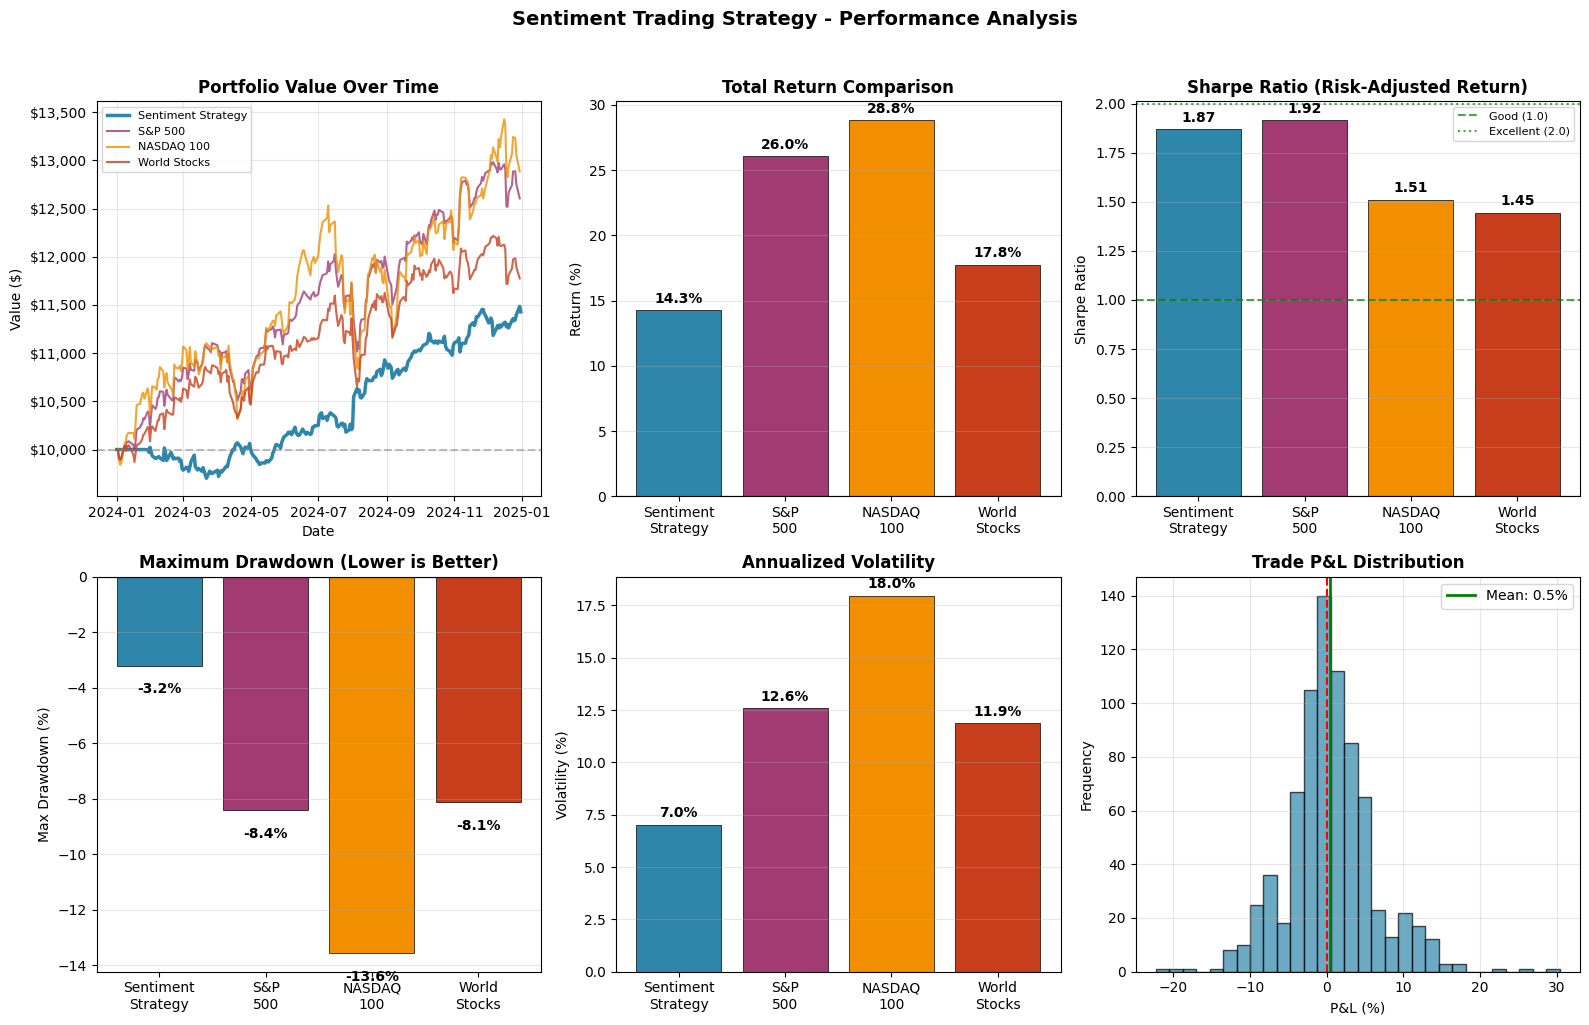


📊 Strategy Sharpe Ratio: 1.87
📈 Total Return: 14.28%
📉 Max Drawdown: -3.20%


In [26]:
# Create visualization with 6 key charts (2x3 grid)
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Color scheme
colors = {
    'Sentiment Strategy': '#2E86AB',
    'S&P 500': '#A23B72',
    'NASDAQ 100': '#F18F01',
    'World Stocks': '#C73E1D'
}

# === Calculate all metrics for comparison ===
# NOTE: Sharpe uses same formula as best-params.ipynb (no risk-free rate subtraction)
def calc_metrics(portfolio_values, initial_capital):
    returns = portfolio_values.pct_change().dropna()
    total_return = (portfolio_values.iloc[-1] / initial_capital - 1) * 100
    n_days = len(portfolio_values)
    annualized_return = ((portfolio_values.iloc[-1] / initial_capital) ** (252 / n_days) - 1) * 100
    volatility = returns.std() * np.sqrt(252) * 100
    # Sharpe ratio (same as best-params.ipynb - no risk-free rate)
    sharpe = (returns.mean() / returns.std() * np.sqrt(252)) if returns.std() > 0 else 0
    cummax = portfolio_values.cummax()
    drawdown = (portfolio_values - cummax) / cummax
    max_drawdown = drawdown.min() * 100
    return {
        'total_return': total_return,
        'annualized_return': annualized_return,
        'volatility': volatility,
        'sharpe': sharpe,
        'max_drawdown': max_drawdown
    }

# Calculate for all
strategy_m = calc_metrics(portfolio_history['portfolio_value'], INITIAL_CAPITAL)
benchmark_m = {name: calc_metrics(returns, INITIAL_CAPITAL) for name, returns in benchmark_returns.items()}

# Common setup
names = ['Sentiment\nStrategy'] + [n.replace(' ', '\n') for n in benchmark_returns.keys()]
bar_colors = [colors['Sentiment Strategy']] + [colors.get(n, 'gray') for n in benchmark_returns.keys()]

# === 1. Portfolio Value Comparison (Top Left) ===
ax1 = axes[0, 0]
portfolio_history['date'] = pd.to_datetime(portfolio_history['date'])
ax1.plot(portfolio_history['date'], portfolio_history['portfolio_value'], 
         label='Sentiment Strategy', color=colors['Sentiment Strategy'], linewidth=2.5)
for name, returns in benchmark_returns.items():
    ax1.plot(returns.index, returns.values, label=name, color=colors.get(name, 'gray'), 
             linewidth=1.5, alpha=0.8)
ax1.axhline(y=INITIAL_CAPITAL, color='gray', linestyle='--', alpha=0.5)
ax1.set_title('Portfolio Value Over Time', fontsize=12, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Value ($)')
ax1.legend(loc='upper left', fontsize=8)
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# === 2. Total Returns Bar Chart (Top Center) ===
ax2 = axes[0, 1]
returns_vals = [strategy_m['total_return']] + [benchmark_m[n]['total_return'] for n in benchmark_returns.keys()]
bars = ax2.bar(names, returns_vals, color=bar_colors, edgecolor='black', linewidth=0.5)
for bar, val in zip(bars, returns_vals):
    height = bar.get_height()
    ax2.annotate(f'{val:.1f}%', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10, fontweight='bold')
ax2.axhline(y=0, color='black', linewidth=0.8)
ax2.set_title('Total Return Comparison', fontsize=12, fontweight='bold')
ax2.set_ylabel('Return (%)')
ax2.grid(True, alpha=0.3, axis='y')

# === 3. Sharpe Ratio Comparison (Top Right) ===
ax3 = axes[0, 2]
sharpe_vals = [strategy_m['sharpe']] + [benchmark_m[n]['sharpe'] for n in benchmark_returns.keys()]
bars3 = ax3.bar(names, sharpe_vals, color=bar_colors, edgecolor='black', linewidth=0.5)
for bar, val in zip(bars3, sharpe_vals):
    height = bar.get_height()
    ax3.annotate(f'{val:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10, fontweight='bold')
ax3.axhline(y=0, color='black', linewidth=0.8)
ax3.axhline(y=1, color='green', linewidth=1.5, linestyle='--', alpha=0.7, label='Good (1.0)')
ax3.axhline(y=2, color='green', linewidth=1.5, linestyle=':', alpha=0.7, label='Excellent (2.0)')
ax3.set_title('Sharpe Ratio (Risk-Adjusted Return)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Sharpe Ratio')
ax3.legend(loc='upper right', fontsize=8)
ax3.grid(True, alpha=0.3, axis='y')

# === 4. Max Drawdown Comparison (Bottom Left) ===
ax4 = axes[1, 0]
dd_vals = [strategy_m['max_drawdown']] + [benchmark_m[n]['max_drawdown'] for n in benchmark_returns.keys()]
bars4 = ax4.bar(names, dd_vals, color=bar_colors, edgecolor='black', linewidth=0.5)
for bar, val in zip(bars4, dd_vals):
    height = bar.get_height()
    ax4.annotate(f'{val:.1f}%', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, -12), textcoords="offset points", ha='center', va='top', fontsize=10, fontweight='bold')
ax4.axhline(y=0, color='black', linewidth=0.8)
ax4.set_title('Maximum Drawdown (Lower is Better)', fontsize=12, fontweight='bold')
ax4.set_ylabel('Max Drawdown (%)')
ax4.grid(True, alpha=0.3, axis='y')

# === 5. Volatility Comparison (Bottom Center) ===
ax5 = axes[1, 1]
vol_vals = [strategy_m['volatility']] + [benchmark_m[n]['volatility'] for n in benchmark_returns.keys()]
bars5 = ax5.bar(names, vol_vals, color=bar_colors, edgecolor='black', linewidth=0.5)
for bar, val in zip(bars5, vol_vals):
    height = bar.get_height()
    ax5.annotate(f'{val:.1f}%', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10, fontweight='bold')
ax5.set_title('Annualized Volatility', fontsize=12, fontweight='bold')
ax5.set_ylabel('Volatility (%)')
ax5.grid(True, alpha=0.3, axis='y')

# === 6. Trade P&L Distribution (Bottom Right) ===
ax6 = axes[1, 2]
ax6.hist(trades_df['pnl_pct'], bins=30, color='#2E86AB', edgecolor='black', alpha=0.7)
ax6.axvline(x=0, color='red', linestyle='--', linewidth=1.5)
ax6.axvline(x=trades_df['pnl_pct'].mean(), color='green', linestyle='-', linewidth=2, 
            label=f'Mean: {trades_df["pnl_pct"].mean():.1f}%')
ax6.set_title('Trade P&L Distribution', fontsize=12, fontweight='bold')
ax6.set_xlabel('P&L (%)')
ax6.set_ylabel('Frequency')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.suptitle('Sentiment Trading Strategy - Performance Analysis', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print key metrics
print(f"\n📊 Strategy Sharpe Ratio: {strategy_m['sharpe']:.2f}")
print(f"📈 Total Return: {strategy_m['total_return']:.2f}%")
print(f"📉 Max Drawdown: {strategy_m['max_drawdown']:.2f}%")

## 9. Performance Metrics Summary

In [27]:
# Calculate advanced metrics
def calculate_metrics(portfolio_values, initial_capital):
    """Calculate key performance metrics (Sharpe matches best-params.ipynb formula)."""
    returns = portfolio_values.pct_change().dropna()
    
    # Total return
    total_return = (portfolio_values.iloc[-1] / initial_capital - 1) * 100
    
    # Annualized return (assuming 252 trading days)
    n_days = len(portfolio_values)
    annualized_return = ((portfolio_values.iloc[-1] / initial_capital) ** (252 / n_days) - 1) * 100
    
    # Volatility (annualized)
    volatility = returns.std() * np.sqrt(252) * 100
    
    # Sharpe Ratio (same formula as best-params.ipynb - no risk-free rate)
    sharpe = (returns.mean() / returns.std() * np.sqrt(252)) if returns.std() > 0 else 0
    
    # Max Drawdown
    cummax = portfolio_values.cummax()
    drawdown = (portfolio_values - cummax) / cummax
    max_drawdown = drawdown.min() * 100
    
    # Sortino Ratio (downside deviation)
    negative_returns = returns[returns < 0]
    downside_std = negative_returns.std() * np.sqrt(252) if len(negative_returns) > 0 else 0
    sortino = (returns.mean() / downside_std * np.sqrt(252)) if downside_std > 0 else 0
    
    return {
        'Total Return (%)': total_return,
        'Annualized Return (%)': annualized_return,
        'Volatility (%)': volatility,
        'Sharpe Ratio': sharpe,
        'Sortino Ratio': sortino,
        'Max Drawdown (%)': max_drawdown
    }

# Calculate metrics for strategy
strategy_metrics = calculate_metrics(portfolio_history['portfolio_value'], INITIAL_CAPITAL)

# Calculate metrics for benchmarks
all_metrics = {'Sentiment Strategy': strategy_metrics}
for name, returns in benchmark_returns.items():
    all_metrics[name] = calculate_metrics(returns, INITIAL_CAPITAL)

# Create comparison table
metrics_df = pd.DataFrame(all_metrics).T
metrics_df = metrics_df.round(2)

print("=" * 70)
print("PERFORMANCE METRICS COMPARISON")
print("=" * 70)
print(metrics_df.to_string())
print("=" * 70)

# Highlight best performer
print(f"\n🏆 BEST PERFORMERS:")
print(f"   Highest Return: {metrics_df['Total Return (%)'].idxmax()} ({metrics_df['Total Return (%)'].max():.2f}%)")
print(f"   Best Sharpe: {metrics_df['Sharpe Ratio'].idxmax()} ({metrics_df['Sharpe Ratio'].max():.2f})")
print(f"   Lowest Drawdown: {metrics_df['Max Drawdown (%)'].idxmax()} ({metrics_df['Max Drawdown (%)'].max():.2f}%)")

PERFORMANCE METRICS COMPARISON
                    Total Return (%)  Annualized Return (%)  Volatility (%)  Sharpe Ratio  Sortino Ratio  Max Drawdown (%)
Sentiment Strategy             14.28                  13.70            7.03          1.87           0.19             -3.20
S&P 500                        26.05                  26.16           12.59          1.92           0.16             -8.41
NASDAQ 100                     28.83                  28.96           17.96          1.51           0.13            -13.56
World Stocks                   17.76                  17.83           11.89          1.45           0.12             -8.13

🏆 BEST PERFORMERS:
   Highest Return: NASDAQ 100 (28.83%)
   Best Sharpe: S&P 500 (1.92)
   Lowest Drawdown: Sentiment Strategy (-3.20%)


## 10. Monthly Performance Breakdown

/var/folders/5k/xsh6xzj10l121lg2lr_6rpkm0000gn/T/ipykernel_31240/1563549164.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_returns = portfolio_history.groupby('month').apply(


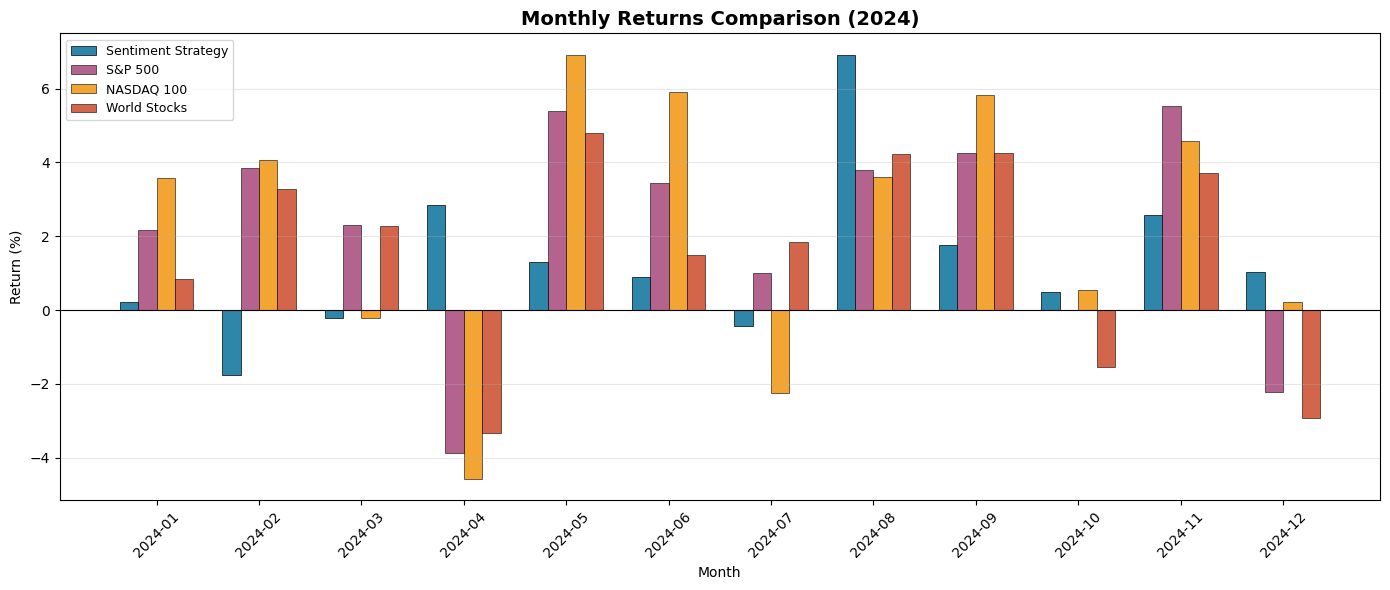


✓ Monthly returns chart saved to outputs/monthly_returns.png


In [28]:
# Monthly returns heatmap
portfolio_history['month'] = portfolio_history['date'].dt.to_period('M')
monthly_returns = portfolio_history.groupby('month').apply(
    lambda x: (x['portfolio_value'].iloc[-1] / x['portfolio_value'].iloc[0] - 1) * 100
)

# Create monthly comparison with benchmarks
fig, ax = plt.subplots(figsize=(14, 6))

months = [str(m) for m in monthly_returns.index]
x = np.arange(len(months))
width = 0.18

# Strategy
bars1 = ax.bar(x - 1.5*width, monthly_returns.values, width, label='Sentiment Strategy', 
               color=colors['Sentiment Strategy'], edgecolor='black', linewidth=0.5)

# Benchmarks
for i, (name, returns) in enumerate(benchmark_returns.items()):
    returns_series = pd.Series(returns.values, index=returns.index)
    returns_series.index = pd.to_datetime(returns_series.index)
    monthly = returns_series.groupby(returns_series.index.to_period('M')).apply(
        lambda x: (x.iloc[-1] / x.iloc[0] - 1) * 100 if len(x) > 0 else 0
    )
    ax.bar(x + (i-0.5)*width, monthly.values[:len(months)], width, label=name,
           color=colors.get(name, 'gray'), edgecolor='black', linewidth=0.5, alpha=0.8)

ax.set_xlabel('Month')
ax.set_ylabel('Return (%)')
ax.set_title('Monthly Returns Comparison (2024)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(months, rotation=45)
ax.legend(loc='upper left', fontsize=9)
ax.axhline(y=0, color='black', linewidth=0.8)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('outputs/monthly_returns.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Monthly returns chart saved to outputs/monthly_returns.png")

## 11. Final Summary

In [29]:
# Final summary
print("=" * 70)
print("SENTIMENT TRADING STRATEGY - FINAL REPORT")
print("=" * 70)
print(f"\n📊 STRATEGY CONFIGURATION:")
print(f"   Initial Capital: ${INITIAL_CAPITAL:,}")
print(f"   Max Position Size: {MAX_POSITION_SIZE*100:.0f}%")
print(f"   Stop Loss: {STOP_LOSS_PCT*100:.0f}%")
print(f"   Take Profit: {TAKE_PROFIT_PCT*100:.0f}%")
print(f"   Max Holding Period: {MAX_HOLDING_DAYS} days")

print(f"\n📈 RESULTS:")
print(f"   Final Portfolio Value: ${portfolio_history['portfolio_value'].iloc[-1]:,.2f}")
print(f"   Total Return: {strategy_metrics['Total Return (%)']:.2f}%")
print(f"   Annualized Return: {strategy_metrics['Annualized Return (%)']:.2f}%")

print(f"\n📉 RISK METRICS:")
print(f"   Volatility: {strategy_metrics['Volatility (%)']:.2f}%")
print(f"   Max Drawdown: {strategy_metrics['Max Drawdown (%)']:.2f}%")
print(f"   Sharpe Ratio: {strategy_metrics['Sharpe Ratio']:.2f}")
print(f"   Sortino Ratio: {strategy_metrics['Sortino Ratio']:.2f}")

print(f"\n🎯 TRADE SUMMARY:")
print(f"   Total Trades: {len(trades_df)}")
print(f"   Win Rate: {len(winning_trades)/len(trades_df)*100:.1f}%")
print(f"   Avg Win: ${winning_trades['pnl'].mean():.2f}" if len(winning_trades) > 0 else "   Avg Win: N/A")
print(f"   Avg Loss: ${losing_trades['pnl'].mean():.2f}" if len(losing_trades) > 0 else "   Avg Loss: N/A")

# Profit factor
gross_profit = winning_trades['pnl'].sum() if len(winning_trades) > 0 else 0
gross_loss = abs(losing_trades['pnl'].sum()) if len(losing_trades) > 0 else 1
profit_factor = gross_profit / gross_loss if gross_loss > 0 else float('inf')
print(f"   Profit Factor: {profit_factor:.2f}")

print(f"\n🏁 BENCHMARK COMPARISON:")
for name in benchmark_returns.keys():
    ret = all_metrics[name]['Total Return (%)']
    diff = strategy_metrics['Total Return (%)'] - ret
    status = "✓ Outperformed" if diff > 0 else "✗ Underperformed"
    print(f"   vs {name}: {status} by {abs(diff):.2f}%")

print("=" * 70)

SENTIMENT TRADING STRATEGY - FINAL REPORT

📊 STRATEGY CONFIGURATION:
   Initial Capital: $10,000
   Max Position Size: 10%
   Stop Loss: 7%
   Take Profit: 10%
   Max Holding Period: 5 days

📈 RESULTS:
   Final Portfolio Value: $11,428.42
   Total Return: 14.28%
   Annualized Return: 13.70%

📉 RISK METRICS:
   Volatility: 7.03%
   Max Drawdown: -3.20%
   Sharpe Ratio: 1.87
   Sortino Ratio: 0.19

🎯 TRADE SUMMARY:
   Total Trades: 771
   Win Rate: 52.7%
   Avg Win: $17.43
   Avg Loss: $-15.33
   Profit Factor: 1.27

🏁 BENCHMARK COMPARISON:
   vs S&P 500: ✗ Underperformed by 11.76%
   vs NASDAQ 100: ✗ Underperformed by 14.55%
   vs World Stocks: ✗ Underperformed by 3.47%
